In [1]:
import numpy as np
import pandas as pd
import zipfile as zp
from pathlib import Path
from gensim.utils import check_output
from sklearn.preprocessing import normalize
from scipy.special import softmax
import shutil
from subprocess import check_output
import torch
from tqdm import tqdm
import colored
import itertools
import matplotlib.pyplot as plt
from scipy.special import softmax
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams.update({'font.size': 16})


In [2]:
def printgr(text):
    print(colored.stylize(text, colored.fg('green')))

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

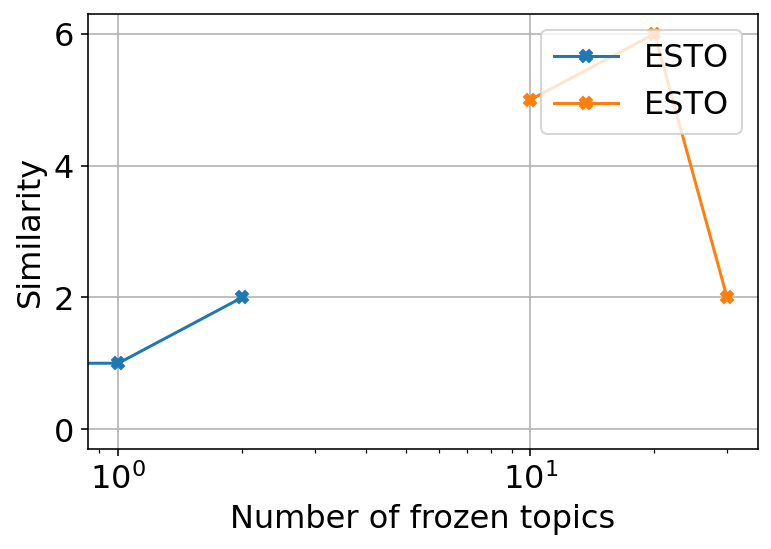

In [4]:
plt.semilogx([0,1,2], [0,1,2], label = "ESTO", marker="X")
plt.semilogx([10,20,30], [5,6,2], label = "ESTO", marker="X")
plt.xlabel('Number of frozen topics', fontsize=16)
plt.ylabel('Similarity', fontsize=16)
plt.legend(loc="upper right")
plt.grid()
plt.show()

In [5]:
#cd /export/usuarios_ml4ds/lbartolome/topicmodeler

In [6]:
#from src.topicmodeling.neural_models.pytorchavitm.datasets.bow_dataset import BOWDataset
#from src.topicmodeling.neural_models.pytorchavitm.avitm_network.avitm import AVITM
#from src.topicmodeling.neural_models.pytorchavitm.utils.data_preparation import prepare_dataset

In [7]:
modelsdir = Path("/export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test")

In [8]:
!git clone https://github.com/MIND-Lab/OCTIS.git

fatal: destination path 'OCTIS' already exists and is not an empty directory.


In [9]:
cd OCTIS

/export/usuarios_ml4ds/lbartolome/topicmodeler/aux/federated/OCTIS


In [10]:
from octis.models.pytorchavitm.avitm import avitm_model as AVITM

In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#from octis.models.pytorchavitm.datasets.bow import BOWDataset

import torch
from torch.utils.data import Dataset


class BOWDataset(Dataset):
    
    """Class to load BOW dataset."""

    def __init__(self, X, idx2token):

        """
        Initializes BOWDataset.

        Parameters
        ----------
        X : array-like, shape=(n_samples, n_features)
            Document-term matrix
        idx2token : list
            A list of feature names
        """
        self.X = X
        self.idx2token = idx2token

    def __len__(self):
        """Returns length of dataset."""
        return len(self.X)

    def __getitem__(self, i):
        """Returns sample from dataset at index i."""
        X = torch.FloatTensor(self.X[i])

        return {'X': X}

def prepare_dataset(corpus, val_size=0.25):
    """It prepares the training data in the format that is asked as input in AVITM.

    Parameters
    ----------
    corpus: List[str]
        List of documents to be used for training of the model
    val_size: float (default=0.25)
        Percentage of the documents to be used for validation

    Returns
    -------
    train_data: BOWDataset
        Training dataset in the required format for AVITM
    val_data: BOWDataset
        Validation dataset in the required format for AVITM
    input_size: int
        Size of the input dimensions of the AVITM model to be trained
    id2token: tuple
        Mappings with the content of each training dataset's document-term matrix.

    """

    # Divide data into training and validation
    docs_train, docs_val = train_test_split(corpus, test_size=val_size, random_state=42)

    # Create a CountVectorizer object to convert a collection of text documents into a matrix of token counts
    # Max and min_df not considered since cleaning is being previously performed
    cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)

    #########################################
    # Prepare train dataset in AVITM format #
    #########################################
    docs_train_conv = [" ".join(docs_train[i]) for i in np.arange(len(docs_train))]

    # Learn the vocabulary dictionary, train_bow = document-term matrix.
    train_bow = cv.fit_transform(docs_train_conv).toarray()

    # Array mapping from feature integer indices to feature name.
    idx2token = cv.get_feature_names_out()
    input_size = len(idx2token)
    id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}

    # The train dataset is an object from the class BOWDataset
    train_data = BOWDataset(train_bow, idx2token)

    ##############################################
    # Prepare validation dataset in AVITM format #
    ##############################################
    docs_val_conv = [" ".join(docs_val[i]) for i in np.arange(len(docs_val))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    return train_data, val_data, input_size, id2token, docs_train, cv

## **1. Creation of synthetic corpus functions**


---

In [12]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

In [13]:
def generateSynthetic(just_inf, gen_docs, vocab_size, n_topics, beta, alpha, n_docs,
                      n_docs_inf, n_docs_global_inf, nwords, alg, n_nodes,
                      frozen_topics, prior_frozen, own_topics, prior_nofrozen):
    
    if just_inf:
        n_total_docs = n_docs_global_inf
    else:
        n_total_docs = n_docs + n_docs_inf

    # Step 1 - generation of topics
    topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
    
    # Step 2 - generation of document topic proportions
    doc_topics_all = []
    for i in np.arange(n_nodes):
        doc_topics = np.random.dirichlet(prior_frozen + prior_nofrozen, n_total_docs)
        prior_nofrozen = rotateArray(prior_nofrozen, len(prior_nofrozen), own_topics)
        doc_topics_all.append(doc_topics)
        
    # Step 3 - Document generation
    documents_all = []
    # z_all = []
    
    if gen_docs:
        for i in np.arange(n_nodes):
            print("Generating document words for node ", str(i))
            documents = [] # Document words
            #z = [] # Assignments
            for docid in tqdm(np.arange(n_total_docs)):
                doc_len = np.random.randint(low=nwords[0], high=nwords[1])
                this_doc_words = []
                #this_doc_assigns = []
                for wd_idx in np.arange(doc_len):

                    tpc = np.nonzero(np.random.multinomial(1, doc_topics_all[i][docid]))[0][0]
                    #this_doc_assigns.append(tpc)
                    if alg == "lda":
                        word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
                    else: #prodlda
                        pval = np.power(topic_vectors[tpc], doc_topics_all[i][docid][tpc])
                        weights = torch.tensor(pval, dtype=torch.float) # create a tensor of weights
                        word = torch.multinomial(weights, 1).numpy()[0]
                        #pval = normalize(pval[:,np.newaxis], norm='l1', axis=0).ravel()
                        #word = np.nonzero(np.random.multinomial(1, b))[0][0]
                    this_doc_words.append('wd'+str(word))
                #z.append(this_doc_assigns)
                documents.append(this_doc_words)
            documents_all.append(documents)
            #z_all.append(z)
    
    return topic_vectors, doc_topics_all, documents_all

## **2. Training and evaluation functions**

---

In [14]:
def create_model_folder(modelname, modelsdir):
    
    # Create model folder and save model training configuration
    modeldir = modelsdir.joinpath(modelname)
    
    if modeldir.exists():

        # Remove current backup folder, if it exists
        old_model_dir = Path(str(modeldir) + '_old/')
        if old_model_dir.exists():
            shutil.rmtree(old_model_dir)

        # Copy current model folder to the backup folder.
        shutil.move(modeldir, old_model_dir)
        print(f'-- -- Creating backup of existing model in {old_model_dir}')

    modeldir.mkdir()
    configFile = modeldir.joinpath('trainconfig.json')
    
    return modeldir, configFile

In [15]:
def convert_topic_word_to_init_size(vocab_size, model, model_type,
                                    ntopics, id2token, all_words):
    """It converts the topic-word distribution matrix obtained from the training of a model into a matrix with the dimensions of the original topic-word distribution, assigning zeros to those words that are not present in the corpus. 
    It is only of use in case we are training a model over a synthetic dataset, so as to later compare the performance of the attained model in what regards to the similarity between the original and the trained model.

    Args:
        * vocab_size (int):       Size of the synethic'data vocabulary.
        * model (AVITM/CTM):      Model whose topic-word matrix is being transformed.
        * model_type (str):       Type of the trained model (e.g. AVITM)
        * ntopics (int):          Number of topics of the trained model.
        * id2token (List[tuple]): Mappings with the content of the document-term matrix.
        * all_words (List[str]):  List of all the words of the vocabulary of size vocab_size.

    Returns:
        * ndarray: Normalized transormed topic-word distribution.
    """
    if model_type == "avitm":
        w_t_distrib = np.zeros((ntopics, vocab_size), dtype=np.float64)
        wd = model.get_topic_word_mat()#get_topic_word_distribution()
        wd = softmax(betas, axis=1)
        for i in np.arange(ntopics):
            for idx, word in id2token.items():
                for j in np.arange(len(all_words)):
                    if all_words[j] == word:
                        w_t_distrib[i, j] = wd[i][idx]
                        break
        normalized_array = normalize(w_t_distrib,axis=1,norm='l1')
        return normalized_array
    else:
        print("Method not impleemnted for the selected model type")
        return None

In [16]:
def train_avitm(modelname, modelsdir, corpus):
    
    # Create model folder
    modeldir, configFile = create_model_folder(modelname, modelsdir)
    
    # Create corpus in ProdLDA format (BoWDataset)
    train_data, val_data, input_size, id2token, docs_train, cv = prepare_dataset(corpus)
    idx2token = train_data.idx2token
    
    #cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)
    #docs = [" ".join(corpus[i]) for i in np.arange(len(corpus))]
    #train_bow = cv.fit_transform(docs).toarray()
    #idx2token = cv.get_feature_names_out()
    #train_dataset = BOWDataset(train_bow, idx2token)
    #input_size = len(idx2token)
    #id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
    
    #avitm = AVITM(logger=None,
    #          input_size=input_size,
    #          n_components=n_topics,
    #          model_type="prodLDA",
    #          hidden_sizes=(100, 100),
    #          activation='softplus',
    #          dropout=0.2,
    #          learn_priors=True,
    #          batch_size=64,
    #          lr=2e-3,
    #          momentum=0.99,
    #          solver='adam',
    #          num_epochs=100,
    #          reduce_on_plateau=False,
    #          topic_prior_mean=0.0,
    #          topic_prior_variance=None,
    #          num_samples=20,
    #          num_data_loader_workers=0,
    #          verbose=True)
    
    avitm = AVITM.AVITM_model(input_size=input_size,
                  num_topics=n_topics,
                  model_type='prodLDA',
                  hidden_sizes=(100, 100),
                  activation='softplus',
                  dropout=0.2,
                  learn_priors=True,
                  batch_size=64,
                  lr=2e-3,
                  momentum=0.99,
                  solver='adam',
                  num_epochs=100,
                  reduce_on_plateau=False,
                  topic_prior_mean=0.0,
                  topic_prior_variance=None,
                  num_samples=10,
                  num_data_loader_workers=0,
                  verbose=False)
    
    
    
    avitm.fit(train_data,val_data)
    
    return modeldir, avitm, cv, id2token, idx2token

In [17]:
def eval_betas(beta, topic_vectors):
    print('Tópicos (equivalentes) evaluados correctamente:')
    score = np.sum(np.max(np.sqrt(beta).dot(np.sqrt(topic_vectors.T)), axis=0))
    printgr(score)
    return score

In [18]:
def eval_thetas(thetas_theoretical, thetas_actual, n_docs):
    sim_mat_theoretical = np.sqrt(thetas_theoretical).dot(np.sqrt(thetas_theoretical.T))
    sim_mat_actual = np.sqrt(thetas_actual).dot(np.sqrt(thetas_actual.T))
    print('Difference in evaluation of doc similarity:')
    score = np.sum(np.abs(sim_mat_theoretical - sim_mat_actual))/n_docs
    printgr(score)
    return score

## **3. Actual training and evaluation**

---

In [19]:
n_nodes = 5

In [20]:
# Topic modeling settings
vocab_size = 5000
n_topics = 50
beta = 1e-2
alpha = 5/n_topics
n_docs = 10000
n_docs_inf = 1000
n_docs_global_inf = 1000#int(n_docs / n_nodes)
nwords = (150, 250) #Min and max lengths of the documents
alg = "lda" #"prod"

tm_settings = {
    "vocab_size": vocab_size,
    "n_topics": n_topics,
    "beta": beta,
    "alpha": alpha,
    "n_docs": n_docs,
    "n_docs_inf": n_docs_inf,
    "n_docs_global_inf": n_docs_global_inf,
    "nwords": nwords,
    "alg": alg
}

In [21]:
# Centralized settings

frozen_topics = 5
prior_frozen = frozen_topics * [alpha]
own_topics = int((n_topics-frozen_topics)/n_nodes)
prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

centralized_settings = {
    "n_nodes": n_nodes,
    "frozen_topics": frozen_topics,
    "prior_frozen": prior_frozen,
    "own_topics": own_topics,
    "prior_nofrozen": prior_nofrozen
}

In [22]:
frozen_topics_list = [5,10,15,40]

sim_betas_centralized = []
sim_thetas_centralized = []
sim_betas_non_colab = []
sim_thetas_non_colab = []
sim_thetas_baseline = []

for frozen_topics in frozen_topics_list:
    print("Executing for frozen topics ", str(frozen_topics))
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    # Baseline doc-topics generation
    topic_vectors, doc_topics_all, _ = generateSynthetic(True, False, **tm_settings, **centralized_settings)

    for i in range(len(doc_topics_all)):
        if i == 0:
            thetas_bas = doc_topics_all[i]
        else:
            thetas_bas = np.concatenate((thetas_bas,doc_topics_all[i]))
    print("Shape of thetas_bas", str(thetas_bas.shape))
    
    # Generate documents
    topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)
    
    # Generate inference corpus and its docs_topics
    inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
    print("Length of the inference corpus ", str(len(inf)))

    for i in range(len(doc_topics_all)):
        if i == 0:
            inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
        else:
            inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
    print("Shape of inf_doc_topics", str(inf_doc_topics.shape))
    
    ########################
    # Centralized training #
    ########################
    print("CENTRALIZED")
    # Define corpus
    corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
    print("Size of centralized corpus ", str(len(corpus)))

    # Train model 
    modelname = "prod_centralized"
    modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)
    
    # Get betas
    betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
    betas = softmax(betas, axis=1)
    print("MAX BETAS: ", np.max(betas))
    print("MIN BETAS: ", np.min(betas))
    all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
    betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                            model=avitm,
                                            model_type="avitm",
                                            ntopics=n_topics,
                                            id2token=id2token,
                                            all_words=all_words)

    # Get thetas
    #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
    #thetas_theoretical = doc_topics_all[0][0:n_docs]

    # Eval betas and thetas
    betas_31 = eval_betas(betas, topic_vectors)
    #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
    sim_betas_centralized.append(betas_31)
    
    # Inference
    # Get inferred thetas
    docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    thetas_inf = np.asarray(avitm.get_thetas(val_data))#get_doc_topic_distribution
    thetas_theoretical = inf_doc_topics

    # Eval thetas
    thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
    sim_thetas_centralized.append(thetas_312)
    
    #############################
    # Non-colaborative training #
    #############################
    betas_nodes = []
    thetas_nodes = []
    for node in range(n_nodes):
        print("NON-COLLABORATIVE of node ", str(node))
        # Define corpus
        corpus = documents_all[node][0:n_docs]
        print("Size of non-collaborative corpus ", str(len(corpus)))

        # Train model 
        modelname = "prodlda_node"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
        betas = softmax(betas, axis=1)
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
        #thetas_theoretical = doc_topics_all[0][0:n_docs]


        # Eval betas and thetas
        betas_32 = eval_betas(betas, topic_vectors)
        betas_nodes.append(betas_32)

        #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_thetas(val_data))#get_doc_topic_distribution

        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        thetas_nodes.append(thetas_322)
    
    avg1 = sum(betas_nodes)/n_nodes
    avg2 = sum(thetas_nodes)/n_nodes
    sim_betas_non_colab.append(avg1)
    print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
    sim_thetas_non_colab.append(avg2)
    
    ########################
    #       Baseline       #
    ########################
    print("BASELINE")
    thetas_theoretical = inf_doc_topics
    thetas_baseline = eval_thetas(thetas_theoretical, thetas_bas, len(thetas_bas))
    sim_thetas_baseline.append(thetas_baseline)

Executing for frozen topics  5
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:38<00:00, 39.48it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:44<00:00, 38.66it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:39<00:00, 39.29it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:49<00:00, 38.05it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:37<00:00, 39.68it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1567.7725960416667	Time: 0:00:07.364112
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1448.809920625	Time: 0:00:00.896771
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1475.5019195833333	Time: 0:00:06.130220
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1407.61252421875	Time: 0:00:00.783715
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1457.678205625	Time: 0:00:05.460878
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1394.806660625	Time: 0:00:00.776167
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1449.8162970833334	Time: 0:00:05.037935
Epoch: [4/100]	Samples: [12500/1250000]	Validation Loss: 1388.1011415625	Time: 0:00:00.809787

Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1417.9243276041666	Time: 0:00:01.025113
Epoch: [7/100]	Samples: [2500/250000]	Validation Loss: 1394.7092611328126	Time: 0:00:00.152411
Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1413.27447109375	Time: 0:00:01.019357
Epoch: [8/100]	Samples: [2500/250000]	Validation Loss: 1385.2086572265625	Time: 0:00:00.155181
Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1409.5850276041667	Time: 0:00:00.917858
Epoch: [9/100]	Samples: [2500/250000]	Validation Loss: 1382.3575857421874	Time: 0:00:00.120196
Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1407.9303705729167	Time: 0:00:00.932475
Epoch: [10/100]	Samples: [2500/250000]	Validation Loss: 1385.2834060546875	Time: 0:00:00.156416
Epoch: [11/100]	Samples: [82500/750000]	Train Loss: 1405.7908833333333	Time: 0:00:01.413052
Epoch: [11/100]	Samples: [2500/250000]	Validation Loss: 1385.6820849609376	Time: 0:00:00.154848
Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1404.70588880208

Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1397.2672296875	Time: 0:00:01.019358
Epoch: [14/100]	Samples: [2500/250000]	Validation Loss: 1366.4468865234376	Time: 0:00:00.155006
Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1395.9553888020832	Time: 0:00:01.004165
Epoch: [15/100]	Samples: [2500/250000]	Validation Loss: 1360.839608984375	Time: 0:00:00.154825
Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1395.9256484375	Time: 0:00:00.919776
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1358.842444140625	Time: 0:00:00.154123
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1395.0642104166666	Time: 0:00:01.007791
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1369.1079677734374	Time: 0:00:00.156968
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1395.6163518229166	Time: 0:00:00.962855
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1363.789150390625	Time: 0:00:00.141389
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1395.353616

Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1404.2840286458334	Time: 0:00:00.999840
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1371.951925	Time: 0:00:00.150596
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1402.7216190104166	Time: 0:00:01.007608
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1370.288110546875	Time: 0:00:00.148424
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1401.0459970052084	Time: 0:00:00.999006
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1367.803918359375	Time: 0:00:00.150835
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1400.2983890625	Time: 0:00:01.008048
Epoch: [19/100]	Samples: [2500/250000]	Validation Loss: 1365.7674078125	Time: 0:00:00.147334
Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1399.8647783854167	Time: 0:00:00.999099
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1366.7941794921876	Time: 0:00:00.150959
Early stopping
Tópicos (equivalentes) evaluados correctamente:
7.35179

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:48<00:00, 38.17it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:35<00:00, 39.98it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:46<00:00, 38.45it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:39<00:00, 39.38it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:46<00:00, 38.40it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1596.7499614583332	Time: 0:00:06.083702
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1489.14242546875	Time: 0:00:00.803424
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1510.776475625	Time: 0:00:05.496389
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1454.0594746875	Time: 0:00:00.794452
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1493.1214997916666	Time: 0:00:05.239914
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1444.90101671875	Time: 0:00:00.668336
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1488.0491877083334	Time: 0:00:05.542401
Epoch: [4/100]	Samples: [12500/1250000]	Validation Loss: 1442.481638125	Time: 0:00:00.7933

Epoch: [29/100]	Samples: [217500/750000]	Train Loss: 1436.32367109375	Time: 0:00:00.943565
Epoch: [29/100]	Samples: [2500/250000]	Validation Loss: 1406.1958158203124	Time: 0:00:00.136511
Epoch: [30/100]	Samples: [225000/750000]	Train Loss: 1436.6060791666666	Time: 0:00:01.060559
Epoch: [30/100]	Samples: [2500/250000]	Validation Loss: 1408.305209765625	Time: 0:00:00.139565
Epoch: [31/100]	Samples: [232500/750000]	Train Loss: 1436.3337981770833	Time: 0:00:01.058245
Epoch: [31/100]	Samples: [2500/250000]	Validation Loss: 1407.264433203125	Time: 0:00:00.165219
Epoch: [32/100]	Samples: [240000/750000]	Train Loss: 1436.95283125	Time: 0:00:00.956038
Epoch: [32/100]	Samples: [2500/250000]	Validation Loss: 1399.517912109375	Time: 0:00:00.143368
Epoch: [33/100]	Samples: [247500/750000]	Train Loss: 1434.2379221354167	Time: 0:00:01.025297
Epoch: [33/100]	Samples: [2500/250000]	Validation Loss: 1407.239168359375	Time: 0:00:00.167877
Epoch: [34/100]	Samples: [255000/750000]	Train Loss: 1435.84333828

Epoch: [30/100]	Samples: [225000/750000]	Train Loss: 1434.6153190104167	Time: 0:00:00.952106
Epoch: [30/100]	Samples: [2500/250000]	Validation Loss: 1400.337196484375	Time: 0:00:00.158814
Epoch: [31/100]	Samples: [232500/750000]	Train Loss: 1434.4702736979166	Time: 0:00:01.047795
Epoch: [31/100]	Samples: [2500/250000]	Validation Loss: 1400.875779296875	Time: 0:00:00.156147
Epoch: [32/100]	Samples: [240000/750000]	Train Loss: 1435.3453203125	Time: 0:00:00.982355
Epoch: [32/100]	Samples: [2500/250000]	Validation Loss: 1397.396730859375	Time: 0:00:00.158388
Epoch: [33/100]	Samples: [247500/750000]	Train Loss: 1434.7312533854167	Time: 0:00:01.035252
Epoch: [33/100]	Samples: [2500/250000]	Validation Loss: 1401.2286271484375	Time: 0:00:00.129368
Epoch: [34/100]	Samples: [255000/750000]	Train Loss: 1435.1274903645833	Time: 0:00:00.985766
Epoch: [34/100]	Samples: [2500/250000]	Validation Loss: 1399.253815234375	Time: 0:00:00.125255
Epoch: [35/100]	Samples: [262500/750000]	Train Loss: 1433.4708

Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1442.1663223958333	Time: 0:00:00.999612
Epoch: [15/100]	Samples: [2500/250000]	Validation Loss: 1411.121589453125	Time: 0:00:00.151086
Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1440.1522645833334	Time: 0:00:00.990187
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1410.9051232421875	Time: 0:00:00.150285
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1441.08665625	Time: 0:00:01.001196
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1410.3926123046874	Time: 0:00:00.150749
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1437.50884140625	Time: 0:00:00.991158
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1403.47780703125	Time: 0:00:00.149493
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1437.4365356770834	Time: 0:00:01.002592
Epoch: [19/100]	Samples: [2500/250000]	Validation Loss: 1401.35366484375	Time: 0:00:00.124161
Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1435.879646093

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:43<00:00, 38.84it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:37<00:00, 39.66it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:47<00:00, 38.27it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:41<00:00, 39.14it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:42<00:00, 38.90it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1621.86271625	Time: 0:00:05.251034
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1525.06636109375	Time: 0:00:00.656009
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1538.6599641666667	Time: 0:00:05.063598
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1496.6748875	Time: 0:00:00.839019
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1520.597928125	Time: 0:00:05.512163
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1480.13092359375	Time: 0:00:00.784988
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1513.731953125	Time: 0:00:05.083733
Epoch: [4/100]	Samples: [12500/1250000]	Validation Loss: 1474.4893796875	Time: 0:00:00.848542
Epoch: [

Epoch: [27/100]	Samples: [202500/750000]	Train Loss: 1464.3865325520833	Time: 0:00:01.215982
Epoch: [27/100]	Samples: [2500/250000]	Validation Loss: 1441.726666796875	Time: 0:00:00.192430
Epoch: [28/100]	Samples: [210000/750000]	Train Loss: 1463.0795171875	Time: 0:00:01.591362
Epoch: [28/100]	Samples: [2500/250000]	Validation Loss: 1440.275034765625	Time: 0:00:00.193905
Epoch: [29/100]	Samples: [217500/750000]	Train Loss: 1462.9063557291668	Time: 0:00:01.214108
Epoch: [29/100]	Samples: [2500/250000]	Validation Loss: 1443.6466453125	Time: 0:00:00.190131
Epoch: [30/100]	Samples: [225000/750000]	Train Loss: 1460.7220234375	Time: 0:00:01.115439
Epoch: [30/100]	Samples: [2500/250000]	Validation Loss: 1437.756611328125	Time: 0:00:00.194734
Epoch: [31/100]	Samples: [232500/750000]	Train Loss: 1462.8948088541667	Time: 0:00:01.132943
Epoch: [31/100]	Samples: [2500/250000]	Validation Loss: 1442.456923046875	Time: 0:00:00.191885
Epoch: [32/100]	Samples: [240000/750000]	Train Loss: 1463.0725091145

Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1499.8331421875	Time: 0:00:01.053694
Epoch: [6/100]	Samples: [2500/250000]	Validation Loss: 1464.7595828125	Time: 0:00:00.152728
Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1493.9809796875	Time: 0:00:01.157078
Epoch: [7/100]	Samples: [2500/250000]	Validation Loss: 1458.477503515625	Time: 0:00:00.146981
Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1488.5189338541666	Time: 0:00:01.177620
Epoch: [8/100]	Samples: [2500/250000]	Validation Loss: 1455.1823388671876	Time: 0:00:00.156698
Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1484.57639296875	Time: 0:00:01.268605
Epoch: [9/100]	Samples: [2500/250000]	Validation Loss: 1456.1288201171874	Time: 0:00:00.149970
Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1479.9609674479166	Time: 0:00:01.172271
Epoch: [10/100]	Samples: [2500/250000]	Validation Loss: 1451.10872421875	Time: 0:00:00.169388
Epoch: [11/100]	Samples: [82500/750000]	Train Loss: 1478.8990682291667	Time: 0:00:

Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1470.3126114583333	Time: 0:00:01.176185
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1435.664672265625	Time: 0:00:00.180441
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1468.0569372395832	Time: 0:00:01.387270
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1430.8119837890624	Time: 0:00:00.152935
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1468.9128752604167	Time: 0:00:01.003904
Epoch: [19/100]	Samples: [2500/250000]	Validation Loss: 1428.222249609375	Time: 0:00:00.151989
Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1468.70028984375	Time: 0:00:01.004146
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1430.4633140625	Time: 0:00:00.152947
Early stopping
Tópicos (equivalentes) evaluados correctamente:
7.968318878773067
Difference in evaluation of doc similarity:
2789.2166666968765
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  10000
-- -- Creating backup of existing mode

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:42<00:00, 39.00it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:42<00:00, 39.00it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:36<00:00, 39.85it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:36<00:00, 39.72it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:35<00:00, 39.96it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1690.209885	Time: 0:00:04.691009
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1607.828949375	Time: 0:00:00.588286
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1618.5880579166667	Time: 0:00:04.760120
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1577.602215625	Time: 0:00:00.678752
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1603.8099541666666	Time: 0:00:04.696321
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1574.30883453125	Time: 0:00:00.611143
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1596.9234075	Time: 0:00:04.620764
Epoch: [4/100]	Samples: [12500/1250000]	Validation Loss: 1567.50332125	Time: 0:00:00.670200
Epoch: [5/

Epoch: [1/100]	Samples: [7500/750000]	Train Loss: 1764.6805432291667	Time: 0:00:01.068994
Epoch: [1/100]	Samples: [2500/250000]	Validation Loss: 1687.084528125	Time: 0:00:00.128800
Epoch: [2/100]	Samples: [15000/750000]	Train Loss: 1693.4387052083334	Time: 0:00:00.923727
Epoch: [2/100]	Samples: [2500/250000]	Validation Loss: 1643.85705	Time: 0:00:00.129312
Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1659.5872783854168	Time: 0:00:01.298892
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1621.705501953125	Time: 0:00:00.128791
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1639.1730549479166	Time: 0:00:00.926687
Epoch: [4/100]	Samples: [2500/250000]	Validation Loss: 1607.791111328125	Time: 0:00:00.132334
Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1626.4625291666666	Time: 0:00:00.930123
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1599.2267396484374	Time: 0:00:00.128620
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1616.4686848958333	Time: 0:00:00.9

Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1594.054090625	Time: 0:00:00.892287
Epoch: [10/100]	Samples: [2500/250000]	Validation Loss: 1578.0538875	Time: 0:00:00.127760
Epoch: [11/100]	Samples: [82500/750000]	Train Loss: 1590.0457276041666	Time: 0:00:00.945319
Epoch: [11/100]	Samples: [2500/250000]	Validation Loss: 1570.6054767578125	Time: 0:00:00.123252
Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1588.1424369791666	Time: 0:00:00.916564
Epoch: [12/100]	Samples: [2500/250000]	Validation Loss: 1571.1095939453126	Time: 0:00:00.127579
Epoch: [13/100]	Samples: [97500/750000]	Train Loss: 1587.1479627604167	Time: 0:00:01.203175
Epoch: [13/100]	Samples: [2500/250000]	Validation Loss: 1570.67031953125	Time: 0:00:00.123100
Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1584.8661901041667	Time: 0:00:00.901833
Epoch: [14/100]	Samples: [2500/250000]	Validation Loss: 1569.44575	Time: 0:00:00.128155
Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1583.2663208333333	Time: 0

Epoch: [23/100]	Samples: [172500/750000]	Train Loss: 1576.2661377604168	Time: 0:00:00.898499
Epoch: [23/100]	Samples: [2500/250000]	Validation Loss: 1572.9621009765624	Time: 0:00:00.125575
Epoch: [24/100]	Samples: [180000/750000]	Train Loss: 1574.8097822916666	Time: 0:00:00.881043
Epoch: [24/100]	Samples: [2500/250000]	Validation Loss: 1565.503604296875	Time: 0:00:00.126673
Epoch: [25/100]	Samples: [187500/750000]	Train Loss: 1574.3930083333332	Time: 0:00:00.891872
Epoch: [25/100]	Samples: [2500/250000]	Validation Loss: 1570.7917234375	Time: 0:00:00.125943
Epoch: [26/100]	Samples: [195000/750000]	Train Loss: 1574.7859408854167	Time: 0:00:00.883015
Epoch: [26/100]	Samples: [2500/250000]	Validation Loss: 1570.36701796875	Time: 0:00:00.127496
Epoch: [27/100]	Samples: [202500/750000]	Train Loss: 1574.5773044270834	Time: 0:00:01.246159
Epoch: [27/100]	Samples: [2500/250000]	Validation Loss: 1567.9212640625	Time: 0:00:00.126141
Epoch: [28/100]	Samples: [210000/750000]	Train Loss: 1574.515566

In [23]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

[8.707365617184003, 8.672562849800663, 8.73682179370435, 8.662954756206085]
[7.237725844164525, 7.621417821059142, 7.9693009858295145, 8.468510073145485]


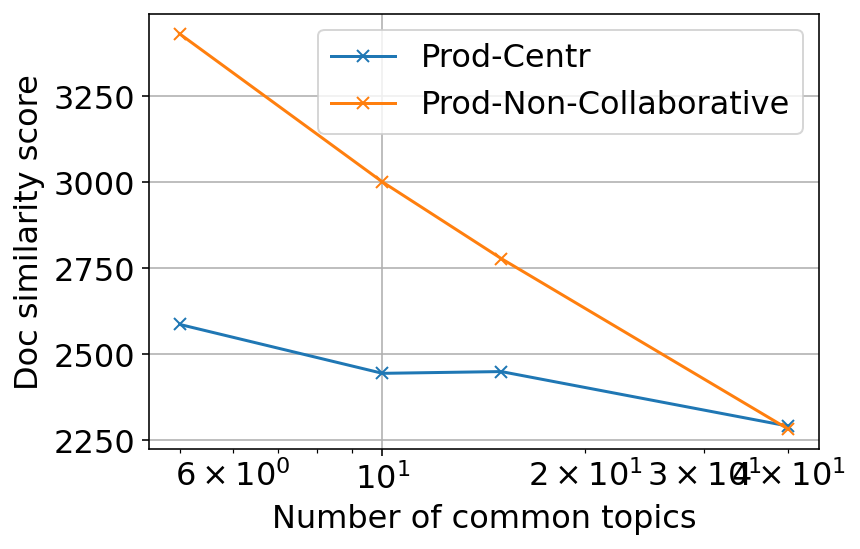

In [24]:
plt.semilogx(frozen_topics_list, sim_thetas_centralized, label="Prod-Centr", marker="x")
plt.semilogx(frozen_topics_list, sim_thetas_non_colab, label="Prod-Non-Collaborative", marker="x")
#plt.plot(frozen_topics_list, sim_thetas_baseline, label="Baseline")
plt.legend(loc="upper right")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Doc similarity score', fontsize=16)
#plt.xticks(frozen_topics_list, [5,10,15,40])
plt.grid()
plt.show()

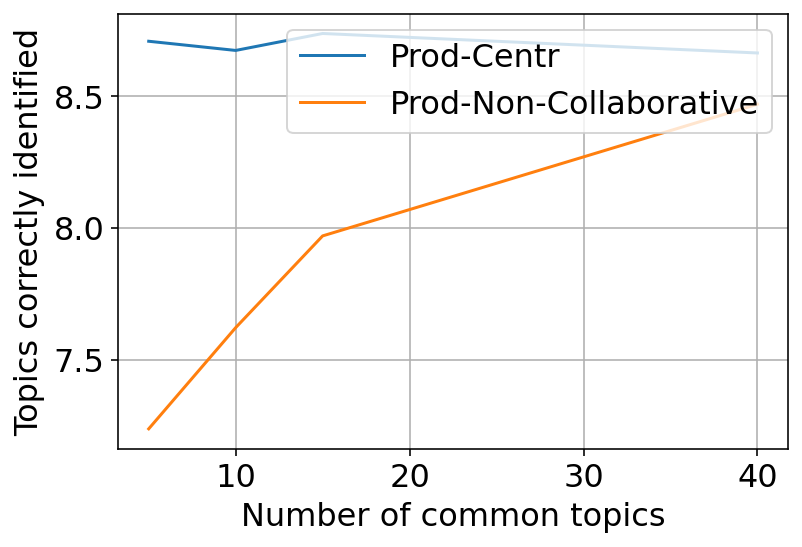

In [25]:
plt.plot(frozen_topics_list, sim_betas_centralized, label="Prod-Centr")
plt.plot(frozen_topics_list, sim_betas_non_colab, label="Prod-Non-Collaborative")
plt.legend(loc="upper right")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Topics correctly identified', fontsize=16)
#plt.xticks(frozen_topics_list, [5,10,15,40])
plt.grid()
plt.show()

In [26]:
frozen_topics_list = [5,10,15,40]
eta_list = [1e-2, 0.02, 0.03, 0.04, 0.08, 1]

sim_betas_centralized = []
sim_thetas_centralized = []
sim_betas_non_colab = []
sim_thetas_non_colab = []

for eta in eta_list:
    print("Executing for eta equals to ", str(eta))
    
    tm_settings["beta"] = eta
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics_list[1] * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    # Generate documents
    topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)
    
    # Generate inference corpus and its docs_topics
    inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
    print("Length of the inference corpus ", str(len(inf)))

    for i in range(len(doc_topics_all)):
        if i == 0:
            inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
        else:
            inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
    print("Shape of inf_doc_topics", str(inf_doc_topics.shape))
    
    ########################
    # Centralized training #
    ########################
    print("CENTRALIZED")
    # Define corpus
    corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
    print("Size of centralized corpus ", str(len(corpus)))

    # Train model 
    modelname = "prod_centralized"
    modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)
    
    # Get betas
    betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
    betas = softmax(betas, axis=1)
    all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
    betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                            model=avitm,
                                            model_type="avitm",
                                            ntopics=n_topics,
                                            id2token=id2token,
                                            all_words=all_words)

    # Get thetas
    #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
    #thetas_theoretical = doc_topics_all[0][0:n_docs]

    # Eval betas and thetas
    betas_31 = eval_betas(betas, topic_vectors)
    #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
    sim_betas_centralized.append(betas_31)
    
    # Inference
    # Get inferred thetas
    docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    thetas_inf = np.asarray(avitm.get_thetas(val_data))#np.asarray(avitm.get_doc_topic_distribution(val_data))
    thetas_theoretical = inf_doc_topics

    # Eval thetas
    thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
    sim_thetas_centralized.append(thetas_312)
    
    #############################
    # Non-colaborative training #
    #############################
    betas_nodes = []
    thetas_nodes = []
    for node in range(n_nodes):
        print("NON-COLLABORATIVE of node ", str(node))
        # Define corpus
        corpus = documents_all[node][0:n_docs]
        print("Size of non-collaborative corpus ", str(len(corpus)))

        # Train model 
        modelname = "prodlda_node"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
        betas = softmax(betas, axis=1)
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
        #thetas_theoretical = doc_topics_all[0][0:n_docs]


        # Eval betas and thetas
        betas_32 = eval_betas(betas, topic_vectors)
        betas_nodes.append(betas_32)

        #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_thetas(val_data))#np.asarray(avitm.get_doc_topic_distribution(val_data))

        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        thetas_nodes.append(thetas_322)
    
    avg1 = sum(betas_nodes)/n_nodes
    avg2 = sum(thetas_nodes)/n_nodes
    sim_betas_non_colab.append(avg1)
    print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
    sim_thetas_non_colab.append(avg2)

Executing for eta equals to  0.01
Generating document words for node  0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:23<00:00, 41.70it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:25<00:00, 41.49it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:26<00:00, 41.31it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:25<00:00, 41.37it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [04:25<00:00, 41.48it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1505.0064639583334	Time: 0:00:04.180398
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1404.5443875	Time: 0:00:00.561916
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1426.2293775	Time: 0:00:04.377885
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1384.17152484375	Time: 0:00:00.606197
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1414.5457710416667	Time: 0:00:04.189259
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1366.7888878125	Time: 0:00:00.576405
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1411.4062241666666	Time: 0:00:04.374692
Epoch: [4/100]	Samples: [12500/1250000]	Validation Loss: 1365.997129375	Time: 0:00:00.614655
Epo

Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1380.7347485677083	Time: 0:00:00.861133
Epoch: [8/100]	Samples: [2500/250000]	Validation Loss: 1355.9477251953124	Time: 0:00:00.116761
Epoch: [9/100]	Samples: [67500/750000]	Train Loss: 1376.4125447916667	Time: 0:00:00.873828
Epoch: [9/100]	Samples: [2500/250000]	Validation Loss: 1357.076290625	Time: 0:00:00.116977
Epoch: [10/100]	Samples: [75000/750000]	Train Loss: 1373.8508609375	Time: 0:00:00.872220
Epoch: [10/100]	Samples: [2500/250000]	Validation Loss: 1357.586193359375	Time: 0:00:00.118475
Epoch: [11/100]	Samples: [82500/750000]	Train Loss: 1372.215573046875	Time: 0:00:00.876774
Epoch: [11/100]	Samples: [2500/250000]	Validation Loss: 1347.2444015625	Time: 0:00:00.117544
Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1370.5745114583333	Time: 0:00:00.893193
Epoch: [12/100]	Samples: [2500/250000]	Validation Loss: 1347.5960005859374	Time: 0:00:00.118006
Epoch: [13/100]	Samples: [97500/750000]	Train Loss: 1368.8833986979166	Time:

Epoch: [35/100]	Samples: [262500/750000]	Train Loss: 1367.39859609375	Time: 0:00:00.873801
Epoch: [35/100]	Samples: [2500/250000]	Validation Loss: 1328.8379126953125	Time: 0:00:00.124554
Epoch: [36/100]	Samples: [270000/750000]	Train Loss: 1365.8816145833334	Time: 0:00:00.959714
Epoch: [36/100]	Samples: [2500/250000]	Validation Loss: 1335.6203275390626	Time: 0:00:00.125555
Epoch: [37/100]	Samples: [277500/750000]	Train Loss: 1365.8562169270833	Time: 0:00:00.878684
Epoch: [37/100]	Samples: [2500/250000]	Validation Loss: 1335.618563671875	Time: 0:00:00.123335
Epoch: [38/100]	Samples: [285000/750000]	Train Loss: 1365.2432669270834	Time: 0:00:00.868665
Epoch: [38/100]	Samples: [2500/250000]	Validation Loss: 1335.6820001953124	Time: 0:00:00.124988
Epoch: [39/100]	Samples: [292500/750000]	Train Loss: 1365.9086833333333	Time: 0:00:00.872952
Epoch: [39/100]	Samples: [2500/250000]	Validation Loss: 1334.5617244140626	Time: 0:00:00.123784
Epoch: [40/100]	Samples: [300000/750000]	Train Loss: 1365.

Epoch: [2/100]	Samples: [15000/750000]	Train Loss: 1443.1114770833333	Time: 0:00:00.818265
Epoch: [2/100]	Samples: [2500/250000]	Validation Loss: 1386.3250431640624	Time: 0:00:00.118689
Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1417.1518390625	Time: 0:00:00.836647
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1372.6944357421876	Time: 0:00:00.114613
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1404.8218052083334	Time: 0:00:00.845785
Epoch: [4/100]	Samples: [2500/250000]	Validation Loss: 1365.8792076171876	Time: 0:00:00.121052
Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1396.7095018229168	Time: 0:00:00.837842
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1369.5242453125	Time: 0:00:00.114538
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1389.4906536458334	Time: 0:00:00.823038
Epoch: [6/100]	Samples: [2500/250000]	Validation Loss: 1358.5448921875	Time: 0:00:00.118600
Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1385.3028533854167	Time: 0:0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:01<00:00, 36.49it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:02<00:00, 36.32it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:02<00:00, 36.38it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:03<00:00, 36.22it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:02<00:00, 36.41it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1574.8369185416666	Time: 0:00:04.681057
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1493.20259546875	Time: 0:00:00.705556
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1505.7127641666666	Time: 0:00:04.580864
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1461.17093140625	Time: 0:00:00.670537
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1490.215345625	Time: 0:00:05.050870
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1451.940339375	Time: 0:00:00.613024
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1486.97408625	Time: 0:00:04.582475
Epoch: [4/100]	Samples: [12500/1250000]	Validation Loss: 1448.6518759375	Time: 0:00:00.662249
Ep

Epoch: [22/100]	Samples: [165000/750000]	Train Loss: 1462.7558627604167	Time: 0:00:00.898703
Epoch: [22/100]	Samples: [2500/250000]	Validation Loss: 1443.425558203125	Time: 0:00:00.132317
Epoch: [23/100]	Samples: [172500/750000]	Train Loss: 1461.8912127604167	Time: 0:00:00.909512
Epoch: [23/100]	Samples: [2500/250000]	Validation Loss: 1446.441733203125	Time: 0:00:00.160949
Epoch: [24/100]	Samples: [180000/750000]	Train Loss: 1461.360876171875	Time: 0:00:00.895145
Epoch: [24/100]	Samples: [2500/250000]	Validation Loss: 1441.0626794921875	Time: 0:00:00.131775
Epoch: [25/100]	Samples: [187500/750000]	Train Loss: 1460.0366765625	Time: 0:00:00.908255
Epoch: [25/100]	Samples: [2500/250000]	Validation Loss: 1440.1298732421874	Time: 0:00:00.128864
Epoch: [26/100]	Samples: [195000/750000]	Train Loss: 1460.2389013020834	Time: 0:00:00.903088
Epoch: [26/100]	Samples: [2500/250000]	Validation Loss: 1440.8952482421876	Time: 0:00:00.131902
Epoch: [27/100]	Samples: [202500/750000]	Train Loss: 1459.924

Epoch: [29/100]	Samples: [217500/750000]	Train Loss: 1457.9194434895833	Time: 0:00:00.885267
Epoch: [29/100]	Samples: [2500/250000]	Validation Loss: 1434.098991796875	Time: 0:00:00.125163
Epoch: [30/100]	Samples: [225000/750000]	Train Loss: 1456.9379096354166	Time: 0:00:00.872758
Epoch: [30/100]	Samples: [2500/250000]	Validation Loss: 1431.54677578125	Time: 0:00:00.126692
Epoch: [31/100]	Samples: [232500/750000]	Train Loss: 1456.0814296875	Time: 0:00:00.884412
Epoch: [31/100]	Samples: [2500/250000]	Validation Loss: 1428.1081771484376	Time: 0:00:00.127155
Epoch: [32/100]	Samples: [240000/750000]	Train Loss: 1456.2687901041666	Time: 0:00:00.879852
Epoch: [32/100]	Samples: [2500/250000]	Validation Loss: 1431.527879296875	Time: 0:00:00.127454
Early stopping
Tópicos (equivalentes) evaluados correctamente:
11.182410993925771
Difference in evaluation of doc similarity:
2388.971773137849
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  10000
-- -- Creating backup of existing mode

Tópicos (equivalentes) evaluados correctamente:
11.139960897592855
Difference in evaluation of doc similarity:
2370.017463887263
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  10000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Epoch: [1/100]	Samples: [7500/750000]	Train Loss: 1643.119515625	Time: 0:00:00.866599
Epoch: [1/100]	Samples: [2500/250000]	Validation Loss: 1521.3557556640626	Time: 0:00:00.116179
Epoch: [2/100]	Samples: [15000/750000]	Train Loss: 1536.0299807291667	Time: 0:00:00.844435
Epoch: [2/100]	Samples: [2500/250000]	Validation Loss: 1481.881596875	Time: 0:00:00.117394
Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1510.6067234375	Time: 0:00:00.870956
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1463.9330439453124	Time: 0:00:00.116746
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1496.5934484375	Time: 0:00:00.837704
Epoch: [4/100]	Samples: [2500/

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:14<00:00, 34.97it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:17<00:00, 34.60it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:19<00:00, 34.42it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:19<00:00, 34.47it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:17<00:00, 34.66it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1608.5981866666666	Time: 0:00:04.960582
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1523.49274484375	Time: 0:00:00.591718
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1540.2440152083334	Time: 0:00:04.566409
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1499.82956140625	Time: 0:00:00.664884
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1526.8353760416667	Time: 0:00:05.007986
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1491.787273125	Time: 0:00:00.685099
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1522.3386983333332	Time: 0:00:04.623798
Epoch: [4/100]	Samples: [12500/1250000]	Validation Loss: 1489.0435634375	Time: 0:00:00.

Epoch: [24/100]	Samples: [180000/750000]	Train Loss: 1502.1165783854167	Time: 0:00:01.031550
Epoch: [24/100]	Samples: [2500/250000]	Validation Loss: 1477.7802279296875	Time: 0:00:00.138980
Epoch: [25/100]	Samples: [187500/750000]	Train Loss: 1501.2676885416668	Time: 0:00:00.958563
Epoch: [25/100]	Samples: [2500/250000]	Validation Loss: 1478.972189453125	Time: 0:00:00.137220
Epoch: [26/100]	Samples: [195000/750000]	Train Loss: 1501.2137481770833	Time: 0:00:00.993117
Epoch: [26/100]	Samples: [2500/250000]	Validation Loss: 1475.0719107421876	Time: 0:00:00.139477
Epoch: [27/100]	Samples: [202500/750000]	Train Loss: 1501.0883705729166	Time: 0:00:01.322608
Epoch: [27/100]	Samples: [2500/250000]	Validation Loss: 1476.4713732421876	Time: 0:00:00.135700
Epoch: [28/100]	Samples: [210000/750000]	Train Loss: 1500.6590807291666	Time: 0:00:00.965708
Epoch: [28/100]	Samples: [2500/250000]	Validation Loss: 1479.88933203125	Time: 0:00:00.140112
Epoch: [29/100]	Samples: [217500/750000]	Train Loss: 1499.

-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Epoch: [1/100]	Samples: [7500/750000]	Train Loss: 1686.4079372395834	Time: 0:00:00.903462
Epoch: [1/100]	Samples: [2500/250000]	Validation Loss: 1579.6488580078126	Time: 0:00:00.118081
Epoch: [2/100]	Samples: [15000/750000]	Train Loss: 1579.24992734375	Time: 0:00:01.229430
Epoch: [2/100]	Samples: [2500/250000]	Validation Loss: 1537.677682421875	Time: 0:00:00.121059
Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1553.5993072916667	Time: 0:00:00.882686
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1520.08169140625	Time: 0:00:00.119252
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1540.64960703125	Time: 0:00:01.024597
Epoch: [4/100]	Samples: [2500/250000]	Validation Loss: 1514.0663271484375	Time: 0:00:00.153238
Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1534.0844489583333	Time: 0:00:01.051104
Epoch: [5/100]	Samples: [2500/25000

Epoch: [11/100]	Samples: [82500/750000]	Train Loss: 1514.3869705729167	Time: 0:00:00.925036
Epoch: [11/100]	Samples: [2500/250000]	Validation Loss: 1487.2234638671875	Time: 0:00:00.122146
Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1511.0936848958333	Time: 0:00:00.908253
Epoch: [12/100]	Samples: [2500/250000]	Validation Loss: 1484.2363955078124	Time: 0:00:00.125028
Epoch: [13/100]	Samples: [97500/750000]	Train Loss: 1511.0669572916668	Time: 0:00:00.910043
Epoch: [13/100]	Samples: [2500/250000]	Validation Loss: 1481.7721822265626	Time: 0:00:00.121457
Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1508.3535411458333	Time: 0:00:01.266054
Epoch: [14/100]	Samples: [2500/250000]	Validation Loss: 1486.104629296875	Time: 0:00:00.123909
Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1507.8852130208334	Time: 0:00:00.912056
Epoch: [15/100]	Samples: [2500/250000]	Validation Loss: 1483.092473828125	Time: 0:00:00.123144
Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1505.85

Tópicos (equivalentes) evaluados correctamente:
14.144366901544451
Difference in evaluation of doc similarity:
2356.033771254548
Nodes averages betas and thetas inf:  14.11415813729983 2371.993202969082
Executing for eta equals to  0.04
Generating document words for node  0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:14<00:00, 34.92it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:18<00:00, 34.57it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:20<00:00, 34.32it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:21<00:00, 34.22it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:18<00:00, 34.59it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1626.5822108333334	Time: 0:00:04.837385
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1550.84559125	Time: 0:00:00.590478
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1564.12991625	Time: 0:00:04.430032
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1526.7796046875	Time: 0:00:00.636302
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1551.6159502083333	Time: 0:00:04.837234
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1520.5124125	Time: 0:00:00.610854
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1546.111706875	Time: 0:00:04.425808
Epoch: [4/100]	Samples: [12500/1250000]	Validation Loss: 1512.7806496875	Time: 0:00:00.641983
Epoch: [

Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1580.7663510416667	Time: 0:00:00.960675
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1538.8264798828125	Time: 0:00:00.125592
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1569.07574140625	Time: 0:00:00.934953
Epoch: [4/100]	Samples: [2500/250000]	Validation Loss: 1534.1537837890626	Time: 0:00:00.128441
Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1561.2885940104168	Time: 0:00:01.267031
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1532.1300466796874	Time: 0:00:00.126360
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1556.5853557291666	Time: 0:00:00.941392
Epoch: [6/100]	Samples: [2500/250000]	Validation Loss: 1526.5110123046875	Time: 0:00:00.127813
Epoch: [7/100]	Samples: [52500/750000]	Train Loss: 1552.8570106770833	Time: 0:00:00.959950
Epoch: [7/100]	Samples: [2500/250000]	Validation Loss: 1521.6749748046875	Time: 0:00:00.126297
Epoch: [8/100]	Samples: [60000/750000]	Train Loss: 1549.8225734375	Time:

Epoch: [47/100]	Samples: [352500/750000]	Train Loss: 1528.0395643229167	Time: 0:00:00.934459
Epoch: [47/100]	Samples: [2500/250000]	Validation Loss: 1502.4937109375	Time: 0:00:00.131835
Epoch: [48/100]	Samples: [360000/750000]	Train Loss: 1526.67801796875	Time: 0:00:00.953800
Epoch: [48/100]	Samples: [2500/250000]	Validation Loss: 1505.527935546875	Time: 0:00:00.132905
Epoch: [49/100]	Samples: [367500/750000]	Train Loss: 1527.6218838541668	Time: 0:00:00.958356
Epoch: [49/100]	Samples: [2500/250000]	Validation Loss: 1503.00962265625	Time: 0:00:00.132036
Epoch: [50/100]	Samples: [375000/750000]	Train Loss: 1526.3500640625	Time: 0:00:00.949265
Epoch: [50/100]	Samples: [2500/250000]	Validation Loss: 1505.37767578125	Time: 0:00:00.134740
Epoch: [51/100]	Samples: [382500/750000]	Train Loss: 1527.8481317708333	Time: 0:00:00.959479
Epoch: [51/100]	Samples: [2500/250000]	Validation Loss: 1504.077107421875	Time: 0:00:00.131956
Epoch: [52/100]	Samples: [390000/750000]	Train Loss: 1527.44218255208

Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1537.3072091145834	Time: 0:00:00.889350
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1517.6203080078126	Time: 0:00:00.124637
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1534.80125703125	Time: 0:00:00.901660
Epoch: [17/100]	Samples: [2500/250000]	Validation Loss: 1517.6602869140625	Time: 0:00:00.124379
Epoch: [18/100]	Samples: [135000/750000]	Train Loss: 1535.18915625	Time: 0:00:00.908473
Epoch: [18/100]	Samples: [2500/250000]	Validation Loss: 1515.945163671875	Time: 0:00:00.124256
Epoch: [19/100]	Samples: [142500/750000]	Train Loss: 1533.7100966145833	Time: 0:00:00.895052
Epoch: [19/100]	Samples: [2500/250000]	Validation Loss: 1514.2878482421875	Time: 0:00:00.124829
Epoch: [20/100]	Samples: [150000/750000]	Train Loss: 1534.5025270833332	Time: 0:00:00.888643
Epoch: [20/100]	Samples: [2500/250000]	Validation Loss: 1510.80776484375	Time: 0:00:00.126884
Epoch: [21/100]	Samples: [157500/750000]	Train Loss: 1533.8756088

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:21<00:00, 34.24it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:19<00:00, 34.43it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:22<00:00, 34.09it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:21<00:00, 34.26it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:21<00:00, 34.17it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1672.4746075	Time: 0:00:04.547805
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1605.74631296875	Time: 0:00:00.590124
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1615.8667333333333	Time: 0:00:04.613376
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1584.5138609375	Time: 0:00:00.652900
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1602.5077179166667	Time: 0:00:04.484089
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1574.46602296875	Time: 0:00:00.605132
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1595.7521577083332	Time: 0:00:04.672959
Epoch: [4/100]	Samples: [12500/1250000]	Validation Loss: 1571.7943728125	Time: 0:00:00.64749

Epoch: [25/100]	Samples: [187500/750000]	Train Loss: 1584.8499135416666	Time: 0:00:00.940769
Epoch: [25/100]	Samples: [2500/250000]	Validation Loss: 1577.2963771484374	Time: 0:00:00.134787
Epoch: [26/100]	Samples: [195000/750000]	Train Loss: 1585.363284375	Time: 0:00:00.933705
Epoch: [26/100]	Samples: [2500/250000]	Validation Loss: 1577.81902734375	Time: 0:00:00.135348
Epoch: [27/100]	Samples: [202500/750000]	Train Loss: 1583.4018979166667	Time: 0:00:00.947278
Epoch: [27/100]	Samples: [2500/250000]	Validation Loss: 1576.7329275390625	Time: 0:00:00.134548
Epoch: [28/100]	Samples: [210000/750000]	Train Loss: 1583.7165734375	Time: 0:00:01.234608
Epoch: [28/100]	Samples: [2500/250000]	Validation Loss: 1576.285584765625	Time: 0:00:00.136588
Epoch: [29/100]	Samples: [217500/750000]	Train Loss: 1583.372771875	Time: 0:00:00.935118
Epoch: [29/100]	Samples: [2500/250000]	Validation Loss: 1574.8428330078125	Time: 0:00:00.135037
Epoch: [30/100]	Samples: [225000/750000]	Train Loss: 1584.28540625	Ti

Epoch: [1/100]	Samples: [7500/750000]	Train Loss: 1759.0763453125	Time: 0:00:00.910334
Epoch: [1/100]	Samples: [2500/250000]	Validation Loss: 1663.003044921875	Time: 0:00:00.124556
Epoch: [2/100]	Samples: [15000/750000]	Train Loss: 1661.5233486979166	Time: 0:00:00.908845
Epoch: [2/100]	Samples: [2500/250000]	Validation Loss: 1610.440954296875	Time: 0:00:00.124801
Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1629.4955981770834	Time: 0:00:01.185300
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1592.2627578125	Time: 0:00:00.125599
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1615.6831158854166	Time: 0:00:00.891381
Epoch: [4/100]	Samples: [2500/250000]	Validation Loss: 1585.1450537109374	Time: 0:00:00.124981
Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1610.60131640625	Time: 0:00:00.891739
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1582.5177537109375	Time: 0:00:00.126349
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1606.04849296875	Time: 0:00:00

Epoch: [1/100]	Samples: [7500/750000]	Train Loss: 1757.3542809895832	Time: 0:00:00.903455
Epoch: [1/100]	Samples: [2500/250000]	Validation Loss: 1656.821405859375	Time: 0:00:00.123540
Epoch: [2/100]	Samples: [15000/750000]	Train Loss: 1661.6087520833332	Time: 0:00:00.897941
Epoch: [2/100]	Samples: [2500/250000]	Validation Loss: 1607.5820177734374	Time: 0:00:00.124764
Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1630.225459375	Time: 0:00:00.900391
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1589.498326171875	Time: 0:00:00.124868
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1617.3756947916668	Time: 0:00:00.884677
Epoch: [4/100]	Samples: [2500/250000]	Validation Loss: 1581.794097265625	Time: 0:00:00.126737
Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1610.1386020833334	Time: 0:00:01.187825
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1581.29033359375	Time: 0:00:00.125105
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1606.51138046875	Time: 0:00:0

Epoch: [1/100]	Samples: [7500/750000]	Train Loss: 1755.9833669270834	Time: 0:00:01.026013
Epoch: [1/100]	Samples: [2500/250000]	Validation Loss: 1666.1065291015625	Time: 0:00:00.154222
Epoch: [2/100]	Samples: [15000/750000]	Train Loss: 1658.0809859375	Time: 0:00:01.018236
Epoch: [2/100]	Samples: [2500/250000]	Validation Loss: 1615.2958134765624	Time: 0:00:00.156434
Epoch: [3/100]	Samples: [22500/750000]	Train Loss: 1625.573415625	Time: 0:00:01.029765
Epoch: [3/100]	Samples: [2500/250000]	Validation Loss: 1598.407434765625	Time: 0:00:00.154627
Epoch: [4/100]	Samples: [30000/750000]	Train Loss: 1611.30080625	Time: 0:00:01.021618
Epoch: [4/100]	Samples: [2500/250000]	Validation Loss: 1588.860548828125	Time: 0:00:00.159911
Epoch: [5/100]	Samples: [37500/750000]	Train Loss: 1603.01491484375	Time: 0:00:01.031748
Epoch: [5/100]	Samples: [2500/250000]	Validation Loss: 1582.609065234375	Time: 0:00:00.155533
Epoch: [6/100]	Samples: [45000/750000]	Train Loss: 1598.906903125	Time: 0:00:01.026745
E

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:22<00:00, 34.14it/s]


Generating document words for node  1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:22<00:00, 34.06it/s]


Generating document words for node  2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:22<00:00, 34.10it/s]


Generating document words for node  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:23<00:00, 34.03it/s]


Generating document words for node  4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [05:21<00:00, 34.20it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 20)
CENTRALIZED
Size of centralized corpus  50000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [37500/3750000]	Train Loss: 1784.4392502083333	Time: 0:00:04.515832
Epoch: [1/100]	Samples: [12500/1250000]	Validation Loss: 1720.837620625	Time: 0:00:00.599856
Epoch: [2/100]	Samples: [75000/3750000]	Train Loss: 1741.1921825	Time: 0:00:04.648393
Epoch: [2/100]	Samples: [12500/1250000]	Validation Loss: 1704.4273378125	Time: 0:00:00.631700
Epoch: [3/100]	Samples: [112500/3750000]	Train Loss: 1713.0110160416666	Time: 0:00:04.543422
Epoch: [3/100]	Samples: [12500/1250000]	Validation Loss: 1694.231945	Time: 0:00:00.613319
Epoch: [4/100]	Samples: [150000/3750000]	Train Loss: 1703.4386039583333	Time: 0:00:04.685782
Epoch: [4/100]	Samples: [12500/1250000]	Validation Loss: 1691.65793125	Time: 0:00:00.633539
Epoch: 

Epoch: [22/100]	Samples: [165000/750000]	Train Loss: 1693.3834302083333	Time: 0:00:01.355004
Epoch: [22/100]	Samples: [2500/250000]	Validation Loss: 1683.39574921875	Time: 0:00:00.145876
Epoch: [23/100]	Samples: [172500/750000]	Train Loss: 1693.0543708333332	Time: 0:00:00.940147
Epoch: [23/100]	Samples: [2500/250000]	Validation Loss: 1682.7478361328126	Time: 0:00:00.149771
Epoch: [24/100]	Samples: [180000/750000]	Train Loss: 1692.7223354166667	Time: 0:00:00.946885
Epoch: [24/100]	Samples: [2500/250000]	Validation Loss: 1683.979183203125	Time: 0:00:00.144492
Epoch: [25/100]	Samples: [187500/750000]	Train Loss: 1692.5052080729167	Time: 0:00:00.955875
Epoch: [25/100]	Samples: [2500/250000]	Validation Loss: 1682.373162890625	Time: 0:00:00.133026
Epoch: [26/100]	Samples: [195000/750000]	Train Loss: 1691.8428942708333	Time: 0:00:00.942423
Epoch: [26/100]	Samples: [2500/250000]	Validation Loss: 1682.3852794921875	Time: 0:00:00.144392
Epoch: [27/100]	Samples: [202500/750000]	Train Loss: 1691.7

Epoch: [31/100]	Samples: [232500/750000]	Train Loss: 1691.9287328125	Time: 0:00:00.923363
Epoch: [31/100]	Samples: [2500/250000]	Validation Loss: 1687.9570619140625	Time: 0:00:00.129852
Epoch: [32/100]	Samples: [240000/750000]	Train Loss: 1691.7118768229166	Time: 0:00:00.926529
Epoch: [32/100]	Samples: [2500/250000]	Validation Loss: 1687.9796630859375	Time: 0:00:00.133338
Epoch: [33/100]	Samples: [247500/750000]	Train Loss: 1691.4091828125	Time: 0:00:00.917011
Epoch: [33/100]	Samples: [2500/250000]	Validation Loss: 1688.57702578125	Time: 0:00:00.129672
Epoch: [34/100]	Samples: [255000/750000]	Train Loss: 1691.3480510416666	Time: 0:00:01.282112
Epoch: [34/100]	Samples: [2500/250000]	Validation Loss: 1688.7659525390625	Time: 0:00:00.133972
Epoch: [35/100]	Samples: [262500/750000]	Train Loss: 1691.039875	Time: 0:00:00.927203
Epoch: [35/100]	Samples: [2500/250000]	Validation Loss: 1688.4519244140624	Time: 0:00:00.129385
Epoch: [36/100]	Samples: [270000/750000]	Train Loss: 1690.777887760416

Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1713.3815572916667	Time: 0:00:00.904675
Epoch: [12/100]	Samples: [2500/250000]	Validation Loss: 1699.206016796875	Time: 0:00:00.127992
Epoch: [13/100]	Samples: [97500/750000]	Train Loss: 1710.2485854166666	Time: 0:00:01.269179
Epoch: [13/100]	Samples: [2500/250000]	Validation Loss: 1697.411201953125	Time: 0:00:00.122907
Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1707.7630005208334	Time: 0:00:00.899362
Epoch: [14/100]	Samples: [2500/250000]	Validation Loss: 1695.9228791015626	Time: 0:00:00.127345
Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1705.2246091145832	Time: 0:00:00.907252
Epoch: [15/100]	Samples: [2500/250000]	Validation Loss: 1694.0256068359374	Time: 0:00:00.124039
Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1703.3244932291666	Time: 0:00:00.903429
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1693.421996875	Time: 0:00:00.127786
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1701.86829

Epoch: [12/100]	Samples: [90000/750000]	Train Loss: 1715.55665625	Time: 0:00:00.894495
Epoch: [12/100]	Samples: [2500/250000]	Validation Loss: 1704.3545501953124	Time: 0:00:00.128700
Epoch: [13/100]	Samples: [97500/750000]	Train Loss: 1711.8175955729166	Time: 0:00:00.898988
Epoch: [13/100]	Samples: [2500/250000]	Validation Loss: 1701.731697265625	Time: 0:00:00.124413
Epoch: [14/100]	Samples: [105000/750000]	Train Loss: 1706.9707825520834	Time: 0:00:00.894951
Epoch: [14/100]	Samples: [2500/250000]	Validation Loss: 1699.8509203125	Time: 0:00:00.128070
Epoch: [15/100]	Samples: [112500/750000]	Train Loss: 1704.22816875	Time: 0:00:00.896032
Epoch: [15/100]	Samples: [2500/250000]	Validation Loss: 1697.6539748046876	Time: 0:00:00.126277
Epoch: [16/100]	Samples: [120000/750000]	Train Loss: 1701.4026346354167	Time: 0:00:01.250754
Epoch: [16/100]	Samples: [2500/250000]	Validation Loss: 1694.65546484375	Time: 0:00:00.127127
Epoch: [17/100]	Samples: [127500/750000]	Train Loss: 1699.3244580729167	T

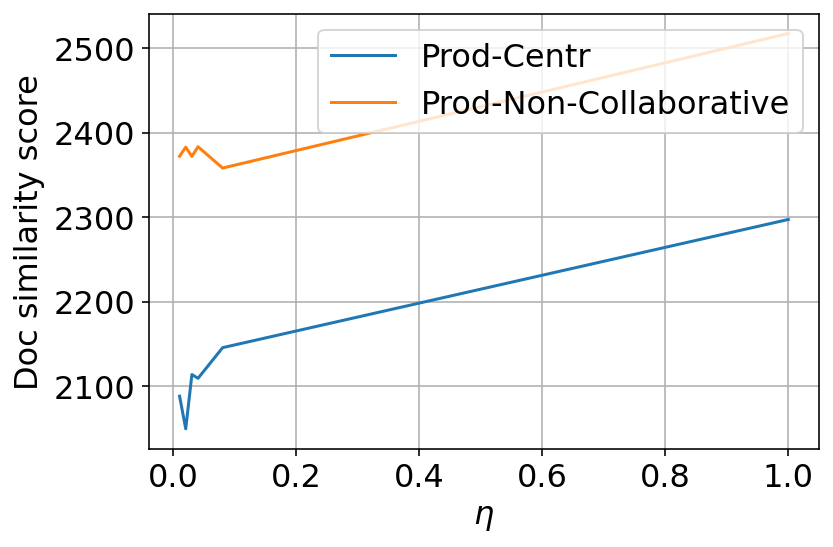

In [30]:
plt.plot(eta_list, sim_thetas_centralized, label="Prod-Centr")
plt.plot(eta_list, sim_thetas_non_colab, label="Prod-Non-Collaborative")
plt.legend(loc="upper right")

plt.xlabel(r'$\eta$', fontsize=16)
plt.ylabel('Doc similarity score', fontsize=16)
#plt.xticks(eta_list, [1e-2, 0.02, 0.03, 0.04, 0.08, 1])
plt.grid()
plt.show()

In [28]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

[7.9609675480925475, 12.00921244552635, 14.6829348553502, 16.79143731782543, 22.65825216864405, 44.29990170647103]
[6.793698523223666, 11.141807210859923, 14.11415813729983, 16.416123817681193, 22.617908915360438, 44.299898736773386]


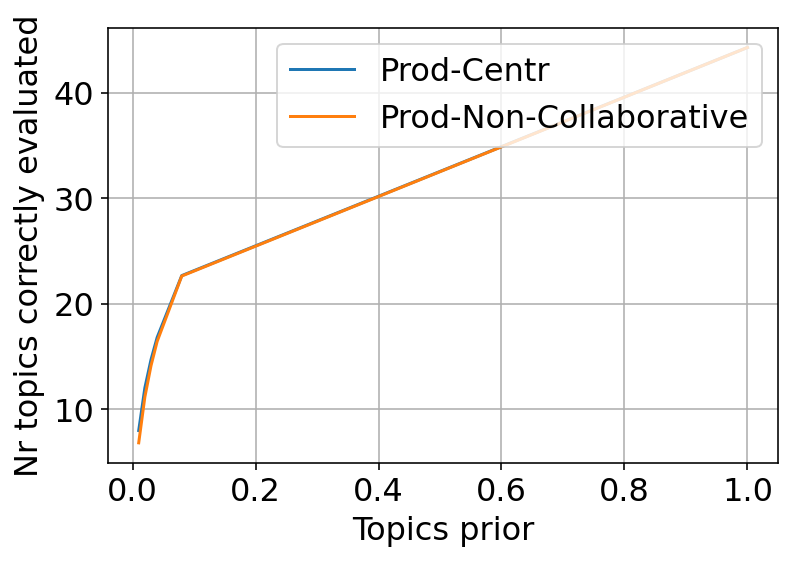

In [31]:
plt.plot(eta_list, sim_betas_centralized, label="Prod-Centr")
plt.plot(eta_list, sim_betas_non_colab, label="Prod-Non-Collaborative")
plt.legend(loc="upper right")

plt.xlabel('Topics prior', fontsize=16)
plt.ylabel('Nr topics correctly evaluated', fontsize=16)
#plt.xticks(eta_list, [1e-2, 0.02, 0.03, 0.04, 0.08, 1])
plt.grid()
plt.show()